<a href="https://colab.research.google.com/github/Irina-Na/TimeSeriesForecasting/blob/main/WattsBattery_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import datetime as dt
import calendar
import matplotlib

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import plotly.graph_objects as go

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

%matplotlib inline
import os


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



True

# Made dataset for each devices

In [ ]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/UB/data"
dataset = pd.DataFrame([])
# Create a list of devices from the folder names 
list_folders = os.listdir("{}/".format(dataset_path))

# Get documents per each device from the corresponding folder
for folder in list_folders:
        list_of_files = os.listdir("{}/{}".format(dataset_path, folder))
        #Sorting by numbers in file name
        files_names=pd.DataFrame({'Names':list_of_files})
        files_names['Count']=[x[3:-4] for x in list_of_files]
        files_names.sort_values('Count', inplace=True)
        list_of_files=files_names.Names.values
         # add to the Pandas data frame each .csv in the folder
        for file in list_of_files:
            if file.find(".csv") != -1 :
                data=pd.read_csv("{}/{}/{}".format(dataset_path, folder, file), sep=';' )
                dataset = dataset.append(data)

# reset index in the final data frame to get identifier column for each document
        dataset = dataset.reset_index(drop=True)
        dataset.to_csv("{}/{}.csv".format(dataset_path, folder) )
        print(dataset.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339938 entries, 0 to 339937
Columns: 31 entries, time to Stack_uptime
dtypes: float64(22), int64(6), object(3)
memory usage: 80.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532941 entries, 0 to 532940
Columns: 31 entries, time to Stack_uptime
dtypes: float64(22), int64(6), object(3)
memory usage: 126.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1720996 entries, 0 to 1720995
Columns: 31 entries, time to Stack_uptime
dtypes: float64(22), int64(6), object(3)
memory usage: 407.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2336188 entries, 0 to 2336187
Columns: 31 entries, time to Stack_uptime
dtypes: float64(22), int64(6), object(3)
memory usage: 552.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4276470 entries, 0 to 4276469
Columns: 31 entries, time to Stack_uptime
dtypes: float64(22), int64(6), object(3)
memory usage: 1011.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeI

In [ ]:
dataset.info

<bound method DataFrame.info of                                 time  ...  Stack_uptime
0        2021-Aug-19 21:03:08.100363  ...       1264954
1        2021-Aug-19 21:03:08.100363  ...       1264954
2        2021-Aug-19 21:03:38.470066  ...       1264984
3        2021-Aug-19 21:03:38.470066  ...       1264984
4        2021-Aug-19 21:04:08.831579  ...       1265015
...                              ...  ...           ...
4883928  2021-Sep-07 13:40:59.596221  ...        106480
4883929  2021-Sep-07 13:40:59.712709  ...        106480
4883930  2021-Sep-07 13:41:04.608093  ...        106485
4883931  2021-Sep-07 13:41:04.608093  ...        106485
4883932  2021-Sep-07 13:41:19.698433  ...        106500

[4883933 rows x 31 columns]>

# Read and explore datasets

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UB/data/1.csv')
df=df[df.num.isin([255])]
df.columns

Index(['Unnamed: 0', 'time', 'num', 'Errors', 'Consumption/battery_from_grid',
       'Consumption/load_from_grid', 'Consumption/battery_from_solar',
       'Consumption/load_from_solar', 'Consumption/load_from_battery',
       'Reserve/charge_level', 'Lowlevel_state', 'Battery/remaining_capacity',
       'Battery/full_capacity', 'Battery/time_to_discharge',
       'MPPT/Input_voltage', 'Temperature/#1', 'Cell/#01', 'Cell/#02',
       'Cell/#03', 'Cell/#04', 'Cell/#05', 'Cell/#06', 'Cell/#07', 'Cell/#08',
       'Cell/#09', 'Cell/#10', 'Cell/#11', 'Cell/#12', 'Cell/#13',
       'Input/RMS_voltage', 'Invertor/output_RMS_voltage', 'Stack_uptime'],
      dtype='object')

In [ ]:
df[['Consumption/load_from_grid', 'Consumption/load_from_solar', 'Consumption/load_from_battery']]

,Consumption/load_from_grid,Consumption/load_from_solar,Consumption/load_from_battery
1,141.0,0.0,0.0
3,140.0,0.0,0.0
5,140.0,0.0,0.0
7,140.0,0.0,0.0
9,140.0,0.0,0.0
...,...,...,...
532932,0.0,0.0,0.0
532934,0.0,0.0,0.0
532936,0.0,0.0,0.0
532938,0.0,0.0,0.0


In [ ]:
cols2=['Errors', 'Consumption/battery_from_grid',
       'Consumption/load_from_grid', 'Consumption/battery_from_solar',
       'Consumption/load_from_solar', 'Consumption/load_from_battery',
       'Reserve/charge_level', 'Lowlevel_state', 'Battery/remaining_capacity',
       'Battery/full_capacity', 'Battery/time_to_discharge',
       'MPPT/Input_voltage', 'Temperature/#1', 'Input/RMS_voltage', 'Invertor/output_RMS_voltage', 'Stack_uptime']

df['Full_consumption']=df['Consumption/load_from_grid']+ df['Consumption/load_from_solar']+ df['Consumption/load_from_battery']

df[['Consumption/load_from_grid','Consumption/load_from_solar','Consumption/load_from_battery', 'Full_consumption']]

,Consumption/load_from_grid,Consumption/load_from_solar,Consumption/load_from_battery,Full_consumption
1,141.0,0.0,0.0,141.0
3,140.0,0.0,0.0,140.0
5,140.0,0.0,0.0,140.0
7,140.0,0.0,0.0,140.0
9,140.0,0.0,0.0,140.0
...,...,...,...,...
532932,0.0,0.0,0.0,0.0
532934,0.0,0.0,0.0,0.0
532936,0.0,0.0,0.0,0.0
532938,0.0,0.0,0.0,0.0


IndexError: ignored

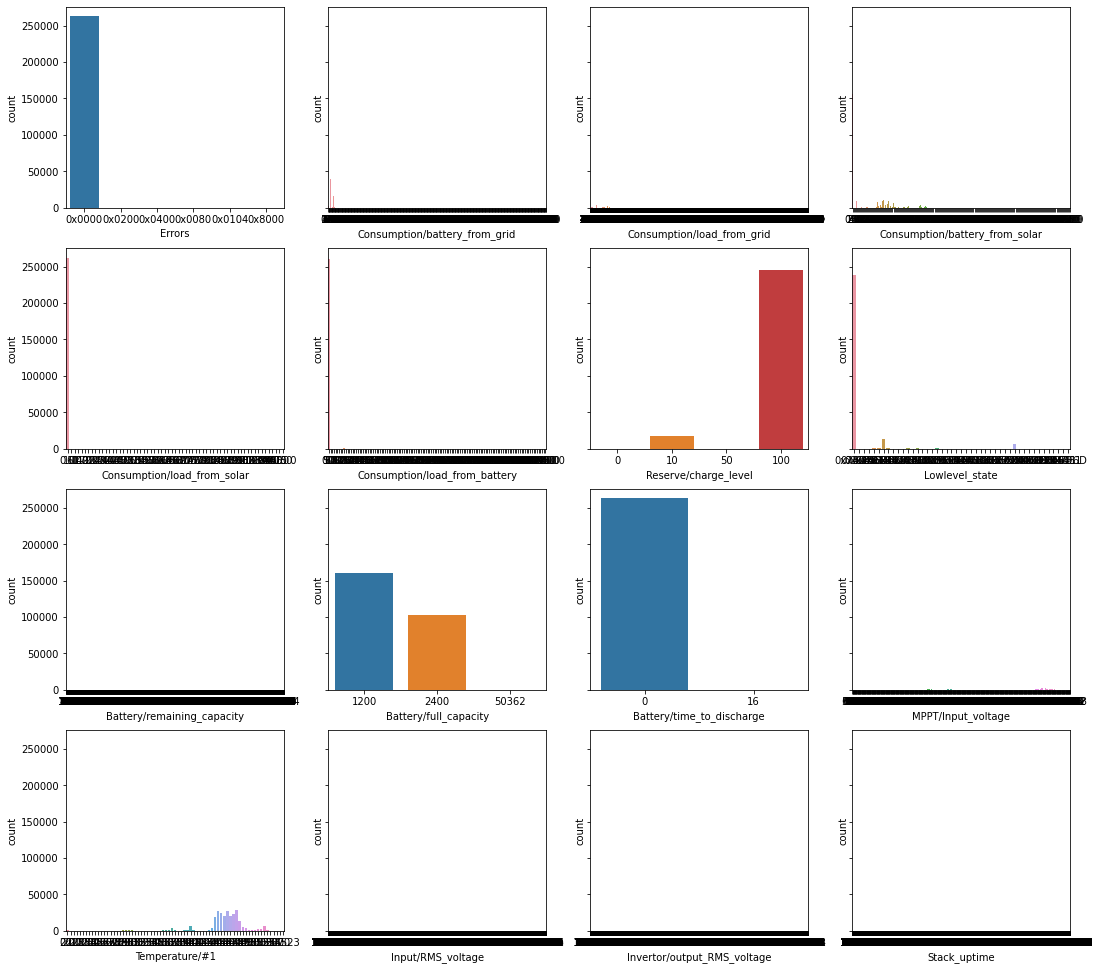

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(18, 17), sharey=True)
for i in range(len(cols2)):
    sns.countplot(x=cols2[i], data=df, ax=axes[int(i/4), int(i%4)])

## Add time features and check if logs is monotonic increasing

In [ ]:
df.time=pd.to_datetime(df.time)
df['Date']=df.time.dt.date
df.set_index('time', inplace=True)
df.index.is_monotonic_increasing

False

There is no continuous sequence in the index. The outliers of the time series are shown in the graph:

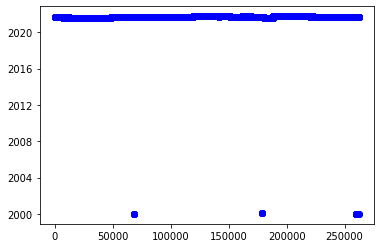

In [ ]:
plt.plot(df.index, 'bo')


There is outliars (from '00 years). Will temporarily delete them and check monotonity

In [ ]:
df=df['Full_consumption'][df['Date'] > datetime.date(2021,1,1)]
df.index.is_monotonic_increasing

False

Unfortunately timeseries don't monotonic. Will explore it:

In [ ]:
df['Time']=df.index

for i in range(1,len(df))[:10000]:
  if df.Time[i] < df.Time[i-1]:
    print(f'Timestamp {i}: {df.Time[i]} after {i-1}  {df.Time[i-1]}')

Timestamp 2404: 2021-08-13 02:40:15.190418 after 2403  2021-08-20 15:20:25.271558
Timestamp 4824: 2021-08-12 08:14:08.524125 after 4823  2021-08-13 19:15:28.135506
Timestamp 7234: 2021-08-10 20:06:31.016932 after 7233  2021-08-13 02:40:00.126429


In [ ]:
df.sort_index(inplace=True)
df.index.is_monotonic_increasing

True

After sorting by index, the timeseries becomes monotonically increasing.

In [ ]:
cols=['Full_consumption', 'Weekday', 'Hour','Reserve/charge_level', 'Lowlevel_state', 'Battery/remaining_capacity',
       'Battery/full_capacity', 'Battery/time_to_discharge',
       'MPPT/Input_voltage', 'Temperature/#1',  'Input/RMS_voltage', 'Invertor/output_RMS_voltage', 'Stack_uptime'  ]

In [ ]:
df[cols].corr()

,Full_consumption,Weekday,Hour,Reserve/charge_level,Battery/remaining_capacity,Battery/full_capacity,Battery/time_to_discharge,MPPT/Input_voltage,Temperature/#1,Input/RMS_voltage,Invertor/output_RMS_voltage,Stack_uptime
Full_consumption,1.000000,0.168842,0.012836,0.077514,0.167760,0.188557,0.163058,0.045127,0.195122,-0.147897,0.030535,-0.017459
Weekday,0.168842,1.000000,-0.021444,0.133911,-0.050194,-0.067393,-0.002825,0.076392,0.047651,-0.007029,-0.102207,-0.032032
Hour,0.012836,-0.021444,1.000000,-0.036265,-0.024999,-0.002455,0.000726,-0.172579,-0.030268,-0.084616,-0.041952,-0.030420
Reserve/charge_level,0.077514,0.133911,-0.036265,1.000000,0.166897,0.038357,-0.008331,0.234052,0.451428,0.272024,0.017358,0.226275
Battery/remaining_capacity,0.167760,-0.050194,-0.024999,0.166897,1.000000,0.953483,0.049086,-0.059395,0.349020,-0.081250,0.159762,0.321030
Battery/full_capacity,0.188557,-0.067393,-0.002455,0.038357,0.953483,1.000000,0.160149,-0.079466,0.244411,-0.190677,0.025807,0.306116
Battery/time_to_discharge,0.163058,-0.002825,0.000726,-0.008331,0.049086,0.160149,1.000000,-0.001751,0.115537,-0.018871,-0.006296,-0.001341
MPPT/Input_voltage,0.045127,0.076392,-0.172579,0.234052,-0.059395,-0.079466,-0.001751,1.000000,0.252259,0.009048,-0.117748,0.077569
Temperature/#1,0.195122,0.047651,-0.030268,0.451428,0.349020,0.244411,0.115537,0.252259,1.000000,0.093734,0.339806,0.129142
Input/RMS_voltage,-0.147897,-0.007029,-0.084616,0.272024,-0.081250,-0.190677,-0.018871,0.009048,0.093734,1.000000,0.143779,0.102812


In [ ]:
df[cols].resample('30T').mean().corr()

,Full_consumption,Weekday,Hour,Reserve/charge_level,Battery/remaining_capacity,Battery/full_capacity,Battery/time_to_discharge,MPPT/Input_voltage,Temperature/#1,Input/RMS_voltage,Invertor/output_RMS_voltage,Stack_uptime
Full_consumption,1.000000,0.213674,0.014793,0.200274,0.126539,0.123769,0.017656,0.077540,0.223409,-0.116143,0.076017,0.031343
Weekday,0.213674,1.000000,-0.026026,0.117825,-0.152322,-0.152395,-0.028215,0.074711,0.005744,-0.025624,-0.148511,-0.086505
Hour,0.014793,-0.026026,1.000000,-0.013995,-0.022763,-0.003727,0.006908,-0.184602,-0.040501,-0.087188,-0.066990,-0.011369
Reserve/charge_level,0.200274,0.117825,-0.013995,1.000000,0.242803,0.175741,-0.073446,0.256392,0.641787,0.204119,-0.012970,0.234848
Battery/remaining_capacity,0.126539,-0.152322,-0.022763,0.242803,1.000000,0.966452,-0.023002,-0.035319,0.309749,0.070358,0.092601,0.566816
Battery/full_capacity,0.123769,-0.152395,-0.003727,0.175741,0.966452,1.000000,0.040395,-0.045536,0.198640,-0.040445,-0.039237,0.594407
Battery/time_to_discharge,0.017656,-0.028215,0.006908,-0.073446,-0.023002,0.040395,1.000000,-0.018716,-0.045360,-0.061380,0.000389,-0.017022
MPPT/Input_voltage,0.077540,0.074711,-0.184602,0.256392,-0.035319,-0.045536,-0.018716,1.000000,0.394630,-0.020676,-0.135906,0.070843
Temperature/#1,0.223409,0.005744,-0.040501,0.641787,0.309749,0.198640,-0.045360,0.394630,1.000000,0.276548,0.306317,0.112407
Input/RMS_voltage,-0.116143,-0.025624,-0.087188,0.204119,0.070358,-0.040445,-0.061380,-0.020676,0.276548,1.000000,0.106253,0.081255


## Find the missing time periods

In [ ]:
df['Time']=list(df.index)
x=[]
for i in range(1,len(df)):
  if (df.Time[i] - df.Time[i-1] )> dt.timedelta(minutes=1):
    print(f'Found timedelta {i} {df.Time[i] - df.Time[i-1]} timestamps: {df.Time[i]} and {df.Time[i-1]}')
    x.append(i)

Found timedelta 106410 2 days 02:02:52.779984 timestamps: 2021-08-30 12:51:33.718134 and 2021-08-28 10:48:40.938150
Found timedelta 106472 0 days 00:04:57.238913 timestamps: 2021-08-30 13:25:20.606823 and 2021-08-30 13:20:23.367910
Found timedelta 106480 0 days 00:01:04.528457 timestamps: 2021-08-30 13:28:26.337166 and 2021-08-30 13:27:21.808709
Found timedelta 113848 1 days 22:33:55.905823 timestamps: 2021-09-03 16:33:19.407313 and 2021-09-01 17:59:23.501490
Found timedelta 113852 0 days 00:02:28.600054 timestamps: 2021-09-03 16:36:44.537963 and 2021-09-03 16:34:15.937909
Found timedelta 116025 0 days 00:07:50.663321 timestamps: 2021-09-04 10:50:57.735765 and 2021-09-04 10:43:07.072444
Found timedelta 116709 0 days 00:02:05.729350 timestamps: 2021-09-04 15:00:46.707963 and 2021-09-04 14:58:40.978613
Found timedelta 116719 0 days 00:01:43.272220 timestamps: 2021-09-04 15:03:42.536958 and 2021-09-04 15:01:59.264738
Found timedelta 116760 0 days 00:03:46.843141 timestamps: 2021-09-04 15:

# Graph of Full_consumption
Have a look on parameter on time

In [ ]:
def Params_sigma_Anomaly_graths_on_time (timeseries, Score, window, sigma):
 
      df_param =timeseries[[Score]] #[45000:50000]    
      # Tail-rolling average transform
      rolling = df_param.rolling(window)     
      
      #df_param['Upp']=df_param[Score][df_param[Score]>(rolling.mean()+sigma*rolling.std())]
      
      #df_param['Low']=df_param[Score][df_param[Score]<(rolling.mean()-sigma*rolling.std())]
      
      #df_param['Anomaly'] = df_param.Upp.fillna(df_param.Low)     
      
      
      # plot original and transformed dataset
      fig = plt.subplots(figsize=(17, 2))
      plt.plot(df_param[Score], 'b', label='parameters scores')
      plt.plot(df_param[Score].rolling(window).mean(), 'g', label='moving average')
      
      #plt.plot(df_param.Anomaly, 'ro', label='3sima anomaly')

      plt.ylabel(Score)
      plt.title(Score+' score')
      plt.legend()


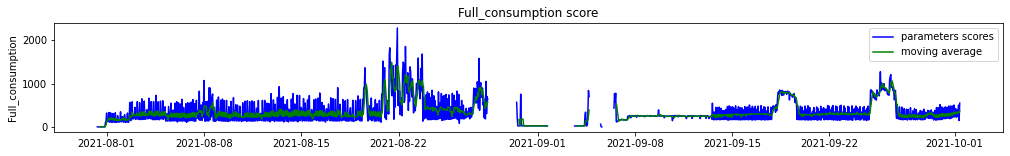

In [ ]:
df_1=df.resample("1H").mean()
Params_sigma_Anomaly_graths_on_time(df_1, 'Full_consumption', 5, 3)